In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD
import matplotlib.pyplot as plt

from data import generate_multivariate_distributions, plot_multivariate_distributions, transition_labels
from prototype import OneLayerNN, HyperparameterSpace, ModelPact
from estimator import inverse_map, HingeLoss, SigmoidLoss, BayesianLoss, NagarajanLoss, NELoss
from illustration import illustrate_decision_boundary
torch.manual_seed(0)

### Generate dataset

In [2]:
cluster_centers = [np.array([-1, -1]), np.array([1, 1])]
dimensions = 2
covariances = [np.eye(dimensions) for _ in range(len(cluster_centers))]
sample_size = 2000
label_list = [-1, 1]
datasets = [generate_multivariate_distributions(cluster_centers, label_list, covariances, sample_size, seed=10*(2**i), to_torch_dataset=True) for i in range(10)]

In [3]:
test_dataset = generate_multivariate_distributions(cluster_centers, label_list, covariances, sample_size, seed=1500, to_torch_dataset=True)

Dataset 1


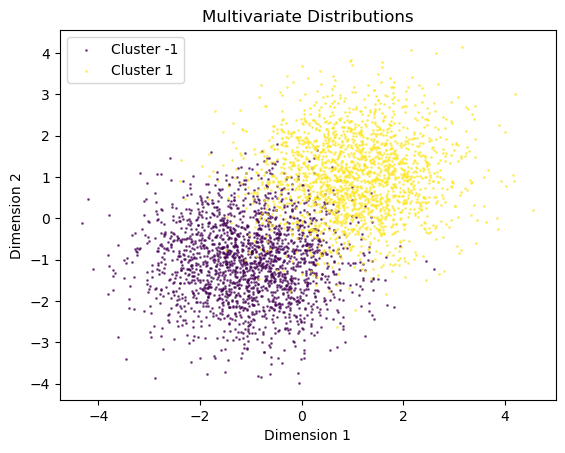

Dataset 2


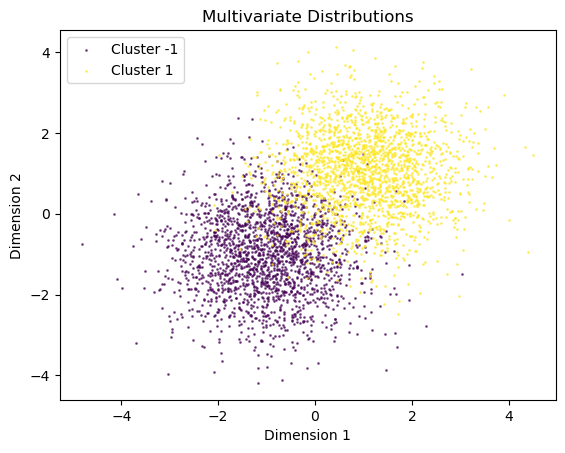

Dataset 3


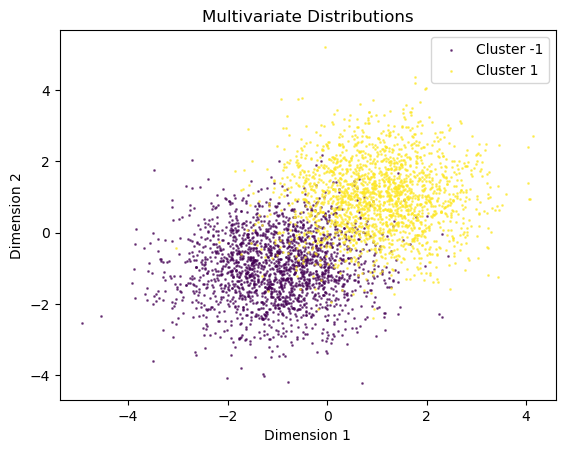

Dataset 4


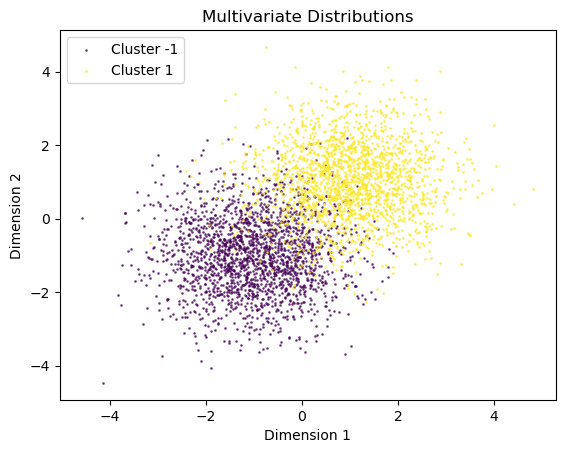

Dataset 5


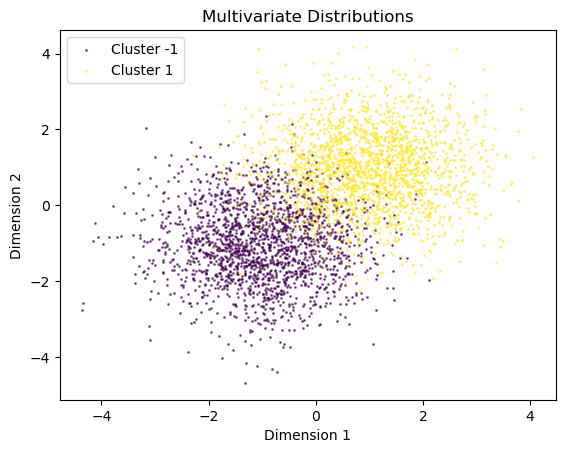

Dataset 6


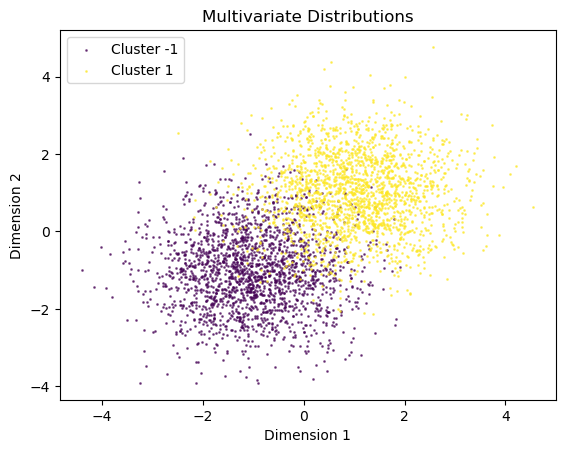

Dataset 7


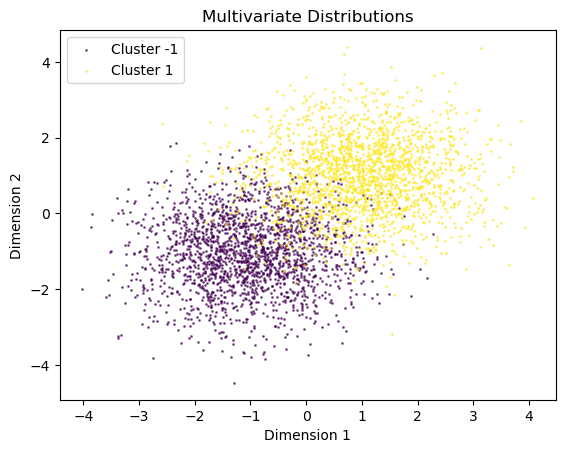

Dataset 8


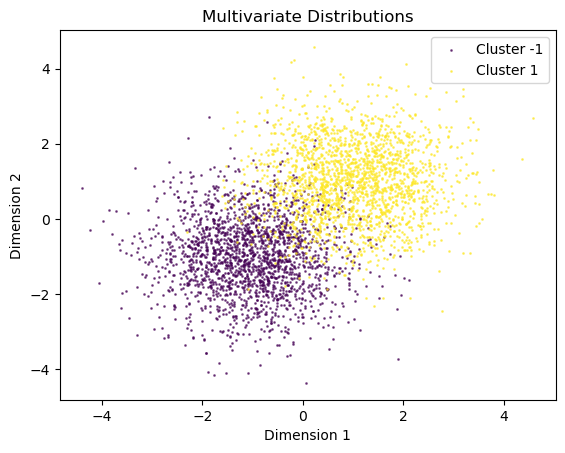

Dataset 9


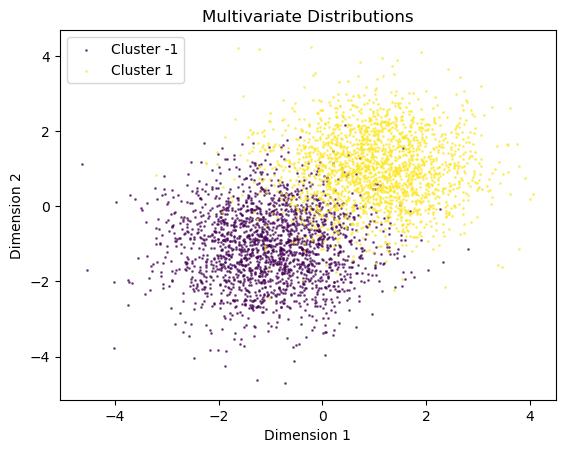

Dataset 10


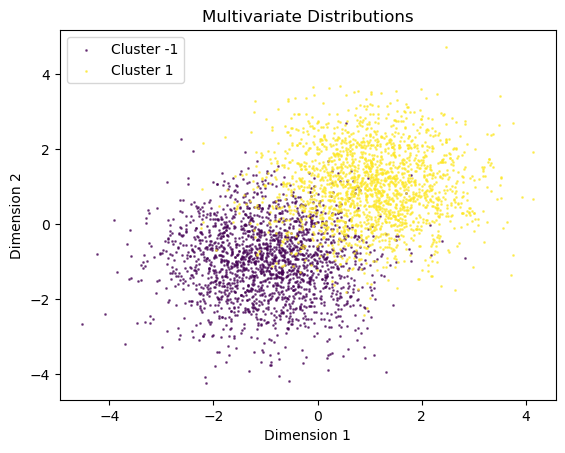

In [4]:
for i, dataset in enumerate(datasets):
    print(f"Dataset {i+1}")
    plot_multivariate_distributions(dataset)

Test Dataset


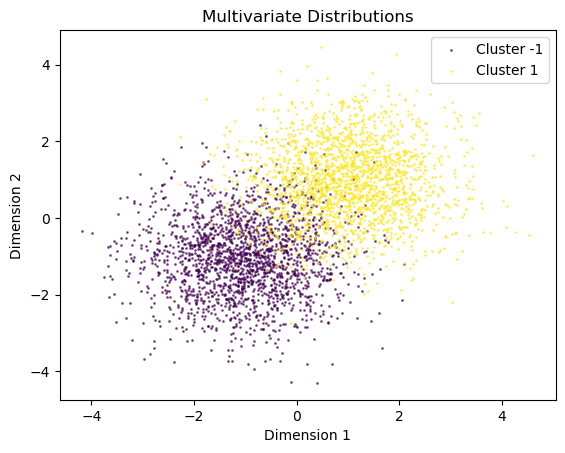

In [5]:
print("Test Dataset")
plot_multivariate_distributions(test_dataset)

### Flip dataset with assigned probability and check it

The checkability remains to be implemented.

In [6]:
# Define the transition probability matrix for flipping the labels
flip_prob = np.array([[0.0, 0.1], [1.0, 0.9]])

corrupted_datasets = []

np.random.seed(65536)

# Iterate through each dataset and flip the labels with the defined probability
for i, dataset in enumerate(datasets):
    data, labels = dataset.tensors[0].clone().detach(), dataset.tensors[1].clone().detach()
    labels = transition_labels(labels, flip_prob, label_list)
    corrupted_datasets.append(TensorDataset(data, torch.tensor(labels, dtype=torch.long)))


In [7]:
corrupted_test_dataset = TensorDataset(test_dataset.tensors[0], torch.tensor(transition_labels(test_dataset.tensors[1], flip_prob, label_list), dtype=torch.long))

Corrupted Dataset 1


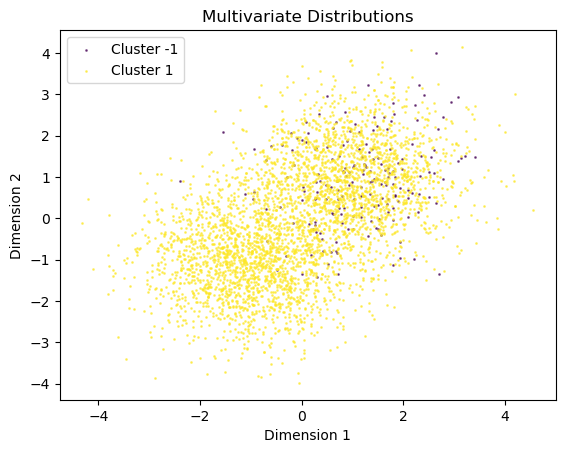

Corrupted Dataset 2


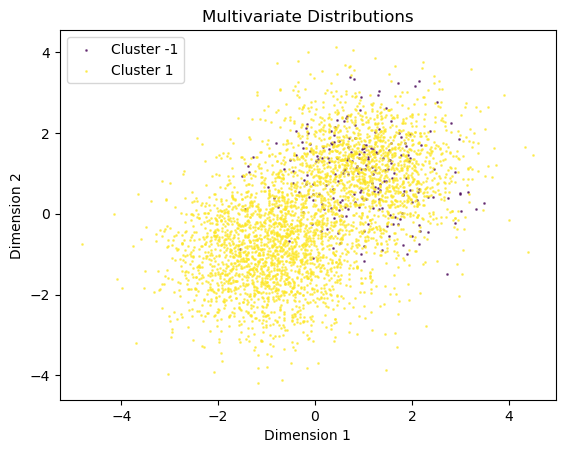

Corrupted Dataset 3


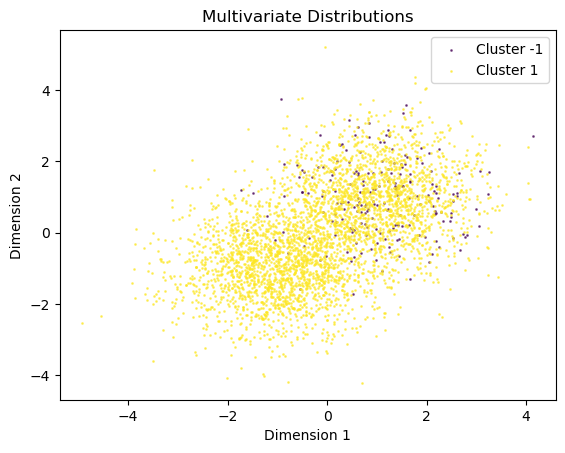

Corrupted Dataset 4


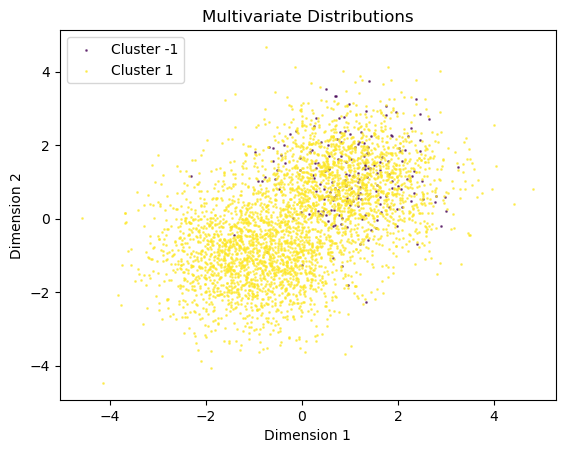

Corrupted Dataset 5


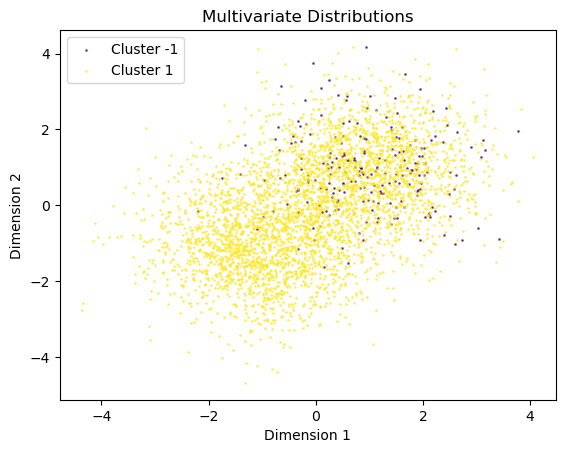

Corrupted Dataset 6


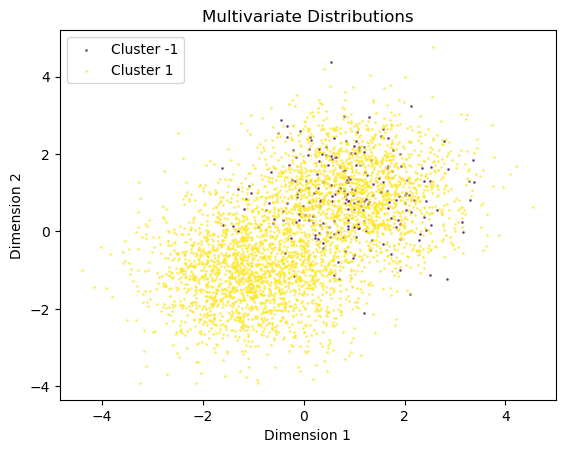

Corrupted Dataset 7


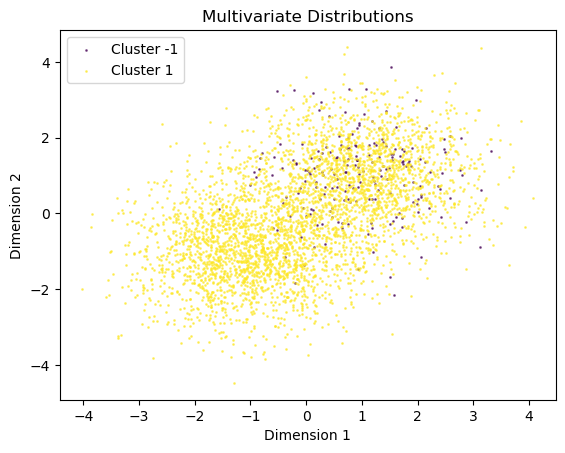

Corrupted Dataset 8


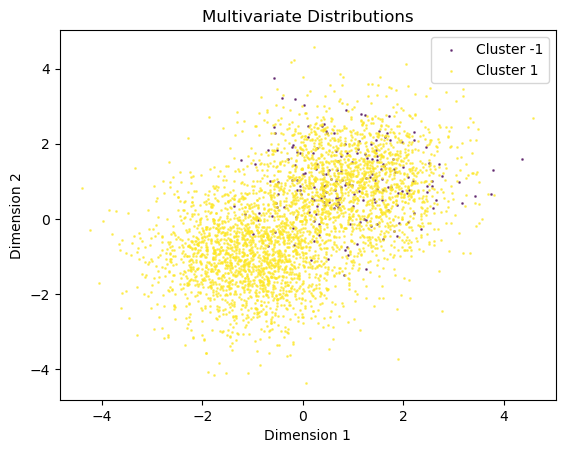

Corrupted Dataset 9


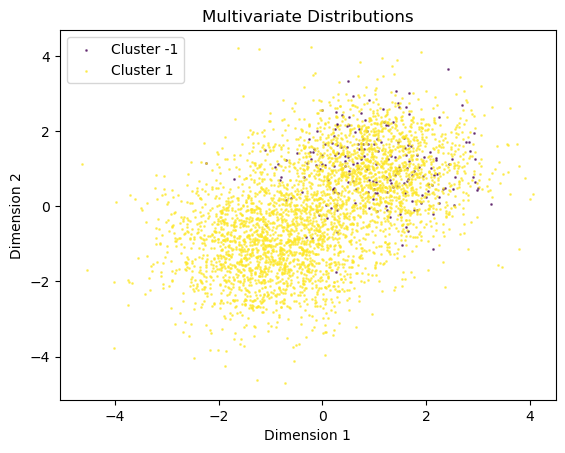

Corrupted Dataset 10


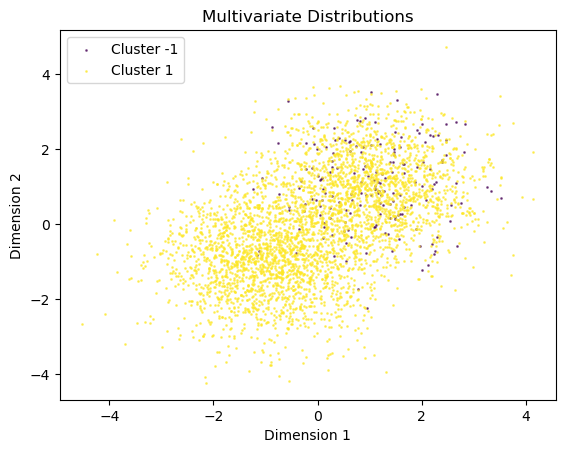

In [8]:
for i, dataset in enumerate(corrupted_datasets):
    data, labels = dataset.tensors
    print(f"Corrupted Dataset {i+1}")
    plot_multivariate_distributions((data.numpy(), labels.numpy()))

### Small scale training test

In [9]:
toy_models = [OneLayerNN(2, 1, name="Toy Sigmoid"), OneLayerNN(2, 1, name="Toy Inv"), OneLayerNN(2, 1, name="Toy Naga")]
toy_criterions = [SigmoidLoss('sum'), BayesianLoss(SigmoidLoss('none'), [[1,0],[0,1]], label_list=label_list, reduction='sum'), NagarajanLoss(SigmoidLoss('none'), [0, 0], reduction='sum')]
toy_pacts = [ModelPact(model, SGD(model.parameters(), 0.005, 0.9), toy_criterions[i], NELoss('sum'), 0.05, 0, 32, plot_loss=True) for i, model in enumerate(toy_models)]

Training Toy Sigmoid
Epoch 1/50, Val Loss: 0.0833, Val Benchmark: 0.0725
Epoch 2/50, Val Loss: 0.0814, Val Benchmark: 0.0725
Epoch 3/50, Val Loss: 0.0803, Val Benchmark: 0.0725
Epoch 4/50, Val Loss: 0.0796, Val Benchmark: 0.0725
Epoch 5/50, Val Loss: 0.0790, Val Benchmark: 0.0725


Epoch 6/50, Val Loss: 0.0786, Val Benchmark: 0.0712
Epoch 7/50, Val Loss: 0.0782, Val Benchmark: 0.0725
Epoch 8/50, Val Loss: 0.0779, Val Benchmark: 0.0725
Epoch 9/50, Val Loss: 0.0776, Val Benchmark: 0.0725
Epoch 10/50, Val Loss: 0.0774, Val Benchmark: 0.0725
Epoch 11/50, Val Loss: 0.0772, Val Benchmark: 0.0725
Epoch 12/50, Val Loss: 0.0771, Val Benchmark: 0.0725
Epoch 13/50, Val Loss: 0.0769, Val Benchmark: 0.0725
Epoch 14/50, Val Loss: 0.0767, Val Benchmark: 0.0725
Epoch 15/50, Val Loss: 0.0766, Val Benchmark: 0.0725
Epoch 16/50, Val Loss: 0.0765, Val Benchmark: 0.0725
Epoch 17/50, Val Loss: 0.0764, Val Benchmark: 0.0725
Epoch 18/50, Val Loss: 0.0763, Val Benchmark: 0.0725
Epoch 19/50, Val Loss: 0.0762, Val Benchmark: 0.0725
Epoch 20/50, Val Loss: 0.0761, Val Benchmark: 0.0725
Epoch 21/50, Val Loss: 0.0761, Val Benchmark: 0.0725
Epoch 22/50, Val Loss: 0.0760, Val Benchmark: 0.0725
Epoch 23/50, Val Loss: 0.0759, Val Benchmark: 0.0725
Epoch 24/50, Val Loss: 0.0758, Val Benchmark: 0.07

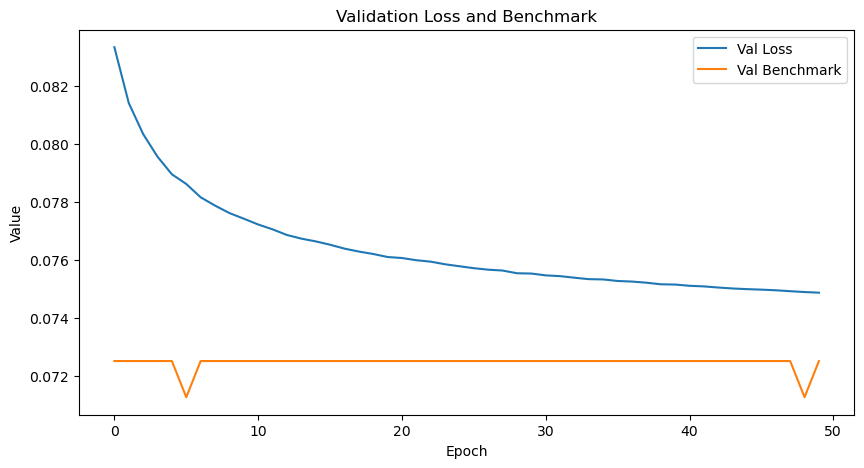

Training Toy Inv
Epoch 1/50, Val Loss: 0.0846, Val Benchmark: 0.0712
Epoch 2/50, Val Loss: 0.0819, Val Benchmark: 0.0700
Epoch 3/50, Val Loss: 0.0802, Val Benchmark: 0.0700
Epoch 4/50, Val Loss: 0.0794, Val Benchmark: 0.0700
Epoch 5/50, Val Loss: 0.0786, Val Benchmark: 0.0700
Epoch 6/50, Val Loss: 0.0782, Val Benchmark: 0.0700
Epoch 7/50, Val Loss: 0.0778, Val Benchmark: 0.0700
Epoch 8/50, Val Loss: 0.0774, Val Benchmark: 0.0700
Epoch 9/50, Val Loss: 0.0770, Val Benchmark: 0.0700
Epoch 10/50, Val Loss: 0.0769, Val Benchmark: 0.0700
Epoch 11/50, Val Loss: 0.0768, Val Benchmark: 0.0712
Epoch 12/50, Val Loss: 0.0763, Val Benchmark: 0.0700
Epoch 13/50, Val Loss: 0.0764, Val Benchmark: 0.0712
Epoch 14/50, Val Loss: 0.0761, Val Benchmark: 0.0700
Epoch 15/50, Val Loss: 0.0761, Val Benchmark: 0.0700
Epoch 16/50, Val Loss: 0.0760, Val Benchmark: 0.0712
Epoch 17/50, Val Loss: 0.0761, Val Benchmark: 0.0700
Epoch 18/50, Val Loss: 0.0759, Val Benchmark: 0.0712
Epoch 19/50, Val Loss: 0.0757, Val Ben

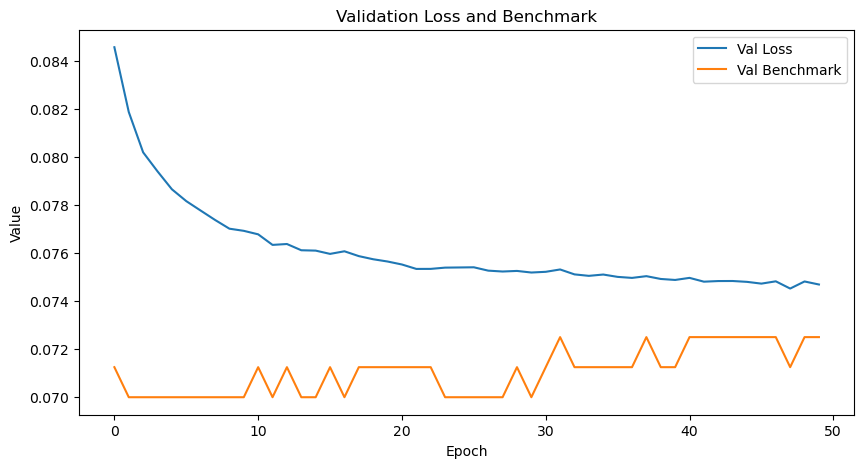

Training Toy Naga
Epoch 1/50, Val Loss: 0.0860, Val Benchmark: 0.0775
Epoch 2/50, Val Loss: 0.0839, Val Benchmark: 0.0775
Epoch 3/50, Val Loss: 0.0825, Val Benchmark: 0.0775
Epoch 4/50, Val Loss: 0.0819, Val Benchmark: 0.0775
Epoch 5/50, Val Loss: 0.0812, Val Benchmark: 0.0775
Epoch 6/50, Val Loss: 0.0807, Val Benchmark: 0.0775
Epoch 7/50, Val Loss: 0.0804, Val Benchmark: 0.0775
Epoch 8/50, Val Loss: 0.0801, Val Benchmark: 0.0775
Epoch 9/50, Val Loss: 0.0799, Val Benchmark: 0.0775
Epoch 10/50, Val Loss: 0.0796, Val Benchmark: 0.0775
Epoch 11/50, Val Loss: 0.0795, Val Benchmark: 0.0775
Epoch 12/50, Val Loss: 0.0794, Val Benchmark: 0.0775
Epoch 13/50, Val Loss: 0.0792, Val Benchmark: 0.0775
Epoch 14/50, Val Loss: 0.0791, Val Benchmark: 0.0775
Epoch 15/50, Val Loss: 0.0790, Val Benchmark: 0.0775
Epoch 16/50, Val Loss: 0.0788, Val Benchmark: 0.0775
Epoch 17/50, Val Loss: 0.0788, Val Benchmark: 0.0775
Epoch 18/50, Val Loss: 0.0787, Val Benchmark: 0.0775
Epoch 19/50, Val Loss: 0.0786, Val Be

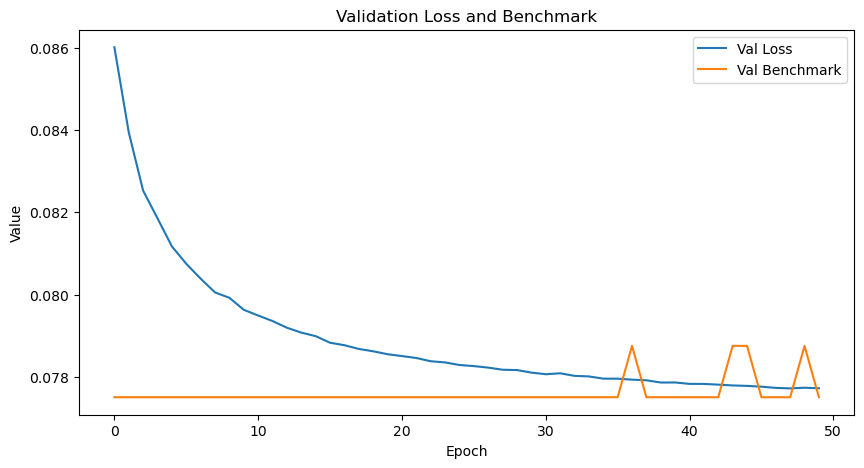

In [10]:
for i, pact in enumerate(toy_pacts):
    print(f"Training {pact.model.name}")
    pact.train(datasets[0])
    pact.evaluate(test_dataset)

Evaluating Toy Sigmoid
Model: Toy Sigmoid, Evaluation Loss: 0.0812, Evaluation Benchmark: 0.0800
Evaluating Toy Inv


Model: Toy Inv, Evaluation Loss: 0.0816, Evaluation Benchmark: 0.0813
Evaluating Toy Naga
Model: Toy Naga, Evaluation Loss: 0.0810, Evaluation Benchmark: 0.0790


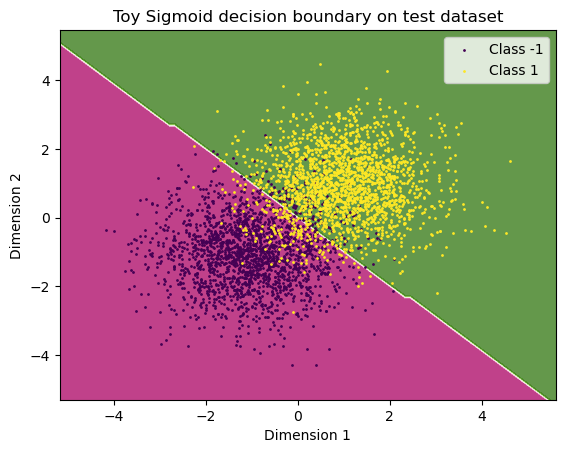

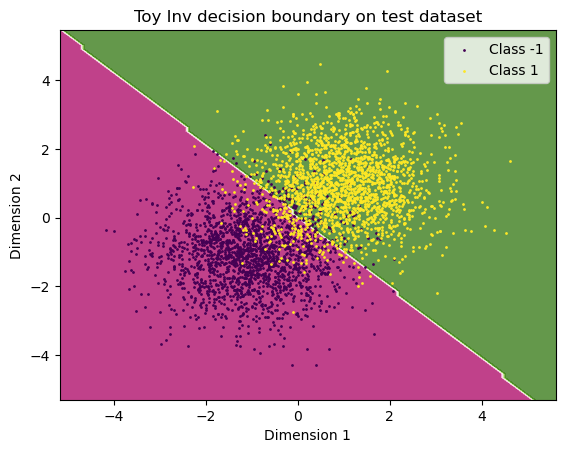

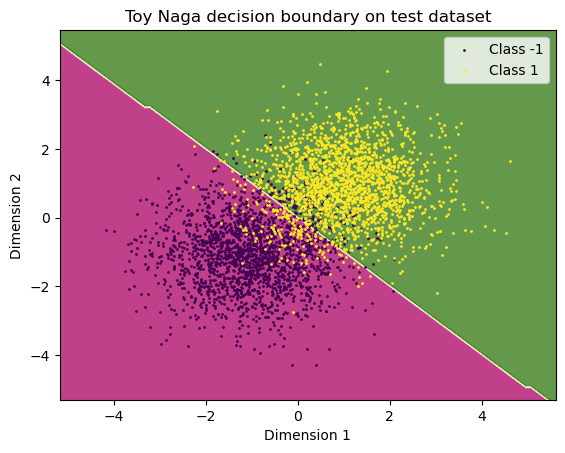

In [11]:
for i, pact in enumerate(toy_pacts):
    print(f"Evaluating {pact.model.name}")
    eval_loss, eval_benchmark = pact.evaluate(test_dataset)
    print(f"Model: {pact.model.name}, Evaluation Loss: {eval_loss:.4f}, Evaluation Benchmark: {eval_benchmark:.4f}")
for i, pact in enumerate(toy_pacts):
    illustrate_decision_boundary(pact.model, test_dataset, name=pact.model.name+' decision boundary on test dataset')

### Cross validation to chosse optimal hyperparameters

In [ ]:
def get_optimal_hyperparameters(model, criterion, benchmark, datasets, hyperparameter_space, epochs=50):
    """
    Get the optimal hyperparameters for a model on datasets 0-3.
    
    Parameters:
    model_class (nn.Module): The model class to optimize.
    criterion (nn.Module): The loss function to use.
    benchmark (nn.Module): The benchmark function to measure performance.
    datasets (list): List of datasets to train on.
    hyperparameter_space (HyperparameterSpace): The hyperparameter space to search.
    epochs (int, optional): Number of epochs to train. Default is 50.
    
    Returns:
    tuple: Optimal hyperparameters (learning_rate, momentum, batch_size).
    """
    best_loss = float('inf')
    best_hyperparameters = None
    
    for learning_rate, momentum, batch_size in hyperparameter_space:
        # model = model_class(2, 1)
        model.reset_parameters()
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        pact = ModelPact(model, optimizer, criterion, benchmark, learning_rate, momentum, batch_size, epochs)
        
        total_loss = 0.0
        for dataset in datasets[:4]:
            val_losses, val_benchmarks = pact.train(dataset)
            # eval_loss, _ = pact.evaluate(dataset)
            total_loss += val_losses[-1]
        
        avg_loss = total_loss / 4
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_hyperparameters = (learning_rate, momentum, batch_size)
        print(f"Learning Rate: {learning_rate}, Momentum: {momentum}, Batch Size: {batch_size}, Average Loss: {avg_loss:.4f}")
    
    return best_hyperparameters

# Example usage
optimal_hyperparameters = get_optimal_hyperparameters(OneLayerNN(2, 1, name="Sigmoid Example"), SigmoidLoss('sum'), NELoss('sum'), datasets, HyperparameterSpace())
print(f"Optimal Hyperparameters: {optimal_hyperparameters}")

Learning Rate: 0.1, Momentum: 0.99, Batch Size: 32, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.99, Batch Size: 64, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.99, Batch Size: 128, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.9, Batch Size: 32, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.9, Batch Size: 64, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.9, Batch Size: 128, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.5, Batch Size: 32, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.5, Batch Size: 64, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.5, Batch Size: 128, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.3, Batch Size: 32, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.3, Batch Size: 64, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.3, Batch Size: 128, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.0, Batch Size: 32, Average Loss: nan
Learning Rate: 0.1, Momentum: 0.0, Batch Size: 64, Average Loss: nan
Learning Rate: 0.1, Momentu

In [ ]:
a = np.array([1])
for i in a:
    print(type(a))
b = [[1, 2], [3, 4], [4, 5]]
# print(np.array(b).shape)
x = torch.tensor([0, 0])
y = torch.tensor([2])
print(x[0], type(x[0]), y[0])
print(y[0], type(y[0]), torch.cat((x, y[0].clone().reshape(1)), 0))
#print(np.where(np.array(label_list) == np.ones(1))[0][0])
#print(np.where(label_list == 1)[0][0])
#print(inverse_map(label_list, -1))

<class 'numpy.ndarray'>
tensor(0) <class 'torch.Tensor'> tensor(2)
tensor(2) <class 'torch.Tensor'> tensor([0, 0, 2])
